# Fina Project

In [41]:
import subprocess
import sys
import pandas as pd
import json
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import date

In [42]:
def install_if_missing(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_if_missing("openmeteo_requests")
install_if_missing("requests_cache")
install_if_missing("retry_requests")
install_if_missing("numpy")
install_if_missing("pandas")

In [43]:
def extract_aqi_features(df, json_col='JSON'):
    """
    Extracts structured air quality and weather data from a parsed JSON column into flat DataFrame columns.
    
    Args:
        df (pd.DataFrame): DataFrame with a column containing parsed JSON dictionaries.
        json_col (str): Name of the column with JSON data (default is 'JSON').
    
    Returns:
        pd.DataFrame: Original DataFrame with new extracted columns.
    """
    
    def extract_value(x, path, default=None):
        """Safely extract a nested value using a path list."""
        try:
            for p in path:
                if isinstance(p, int):  # For list indexing
                    x = x[p]
                else:
                    x = x.get(p, default)
            return x
        except Exception:
            return default

    def extract_forecast_value(x, pollutant, date):
        """Extract forecast daily average for a specific pollutant and date."""
        try:
            forecast_list = x.get('forecast', {}).get('daily', {}).get(pollutant, [])
            for entry in forecast_list:
                if entry.get('day') == date:
                    return entry.get('avg')
        except Exception:
            return None

    # Extract common air quality fields
    df['dominant_pollutant'] = df[json_col].apply(lambda x: x.get('dominentpol'))
    
    pollutants = ['pm25', 'pm10', 'co', 'no2', 'so2', 'o3']
    for pol in pollutants:
        df[pol] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', pol, 'v']))

    # Weather fields
    df['temperature'] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', 't', 'v']))
    df['humidity'] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', 'h', 'v']))
    df['wind_speed'] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', 'w', 'v']))
    df['pressure'] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', 'p', 'v']))
    df['rain'] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', 'r', 'v']))

    # City and location
    df['city_geo_lat'] = df[json_col].apply(lambda x: extract_value(x, ['city', 'geo', 0]))
    df['city_geo_lon'] = df[json_col].apply(lambda x: extract_value(x, ['city', 'geo', 1]))
    # df['city_url'] = df[json_col].apply(lambda x: extract_value(x, ['city', 'url']))
    
    # Time
    # df['aqi_time_iso'] = df[json_col].apply(lambda x: extract_value(x, ['time', 'iso']))
    # df['aqi_time_local'] = df[json_col].apply(lambda x: extract_value(x, ['time', 's']))
    # df['time_zone'] = df[json_col].apply(lambda x: extract_value(x, ['time', 'tz']))

    # Forecast (match the forecast to the date in the row's Timestamp)
    # df['forecast_date'] = pd.to_datetime(df['Timestamp']).dt.strftime('%Y-%m-%d')

    # for pol in ['pm25', 'pm10', 'o3', 'uvi']:
    #     col_name = f'forecast_{pol}_avg'
    #     df[col_name] = df.apply(lambda row: extract_forecast_value(row[json_col], pol, row['forecast_date']), axis=1)

    return df

In [44]:
# read data
df = pd.read_csv("air_data.csv", converters={'JSON': eval})
# view
display(df)

,Timestamp,City,AQI,PM2.5,JSON
0,2025-03-01 12:15:43,Bangkok,86,86,"{'aqi': 86, 'idx': 5773, 'attributions': [{'ur..."
1,2025-03-01 12:15:43,Beijing,261,261,"{'aqi': 261, 'idx': 1451, 'attributions': [{'u..."
2,2025-03-01 12:15:44,Los Angeles,28,28,"{'aqi': 28, 'idx': 243, 'attributions': [{'url..."
3,2025-03-02 04:49:40,Bangkok,78,78,"{'aqi': 78, 'idx': 5773, 'attributions': [{'ur..."
4,2025-03-02 04:49:40,Beijing,74,74,"{'aqi': 74, 'idx': 1451, 'attributions': [{'ur..."
...,...,...,...,...,...
148,2025-04-19 01:47:45,Beijing,97,97,"{'aqi': 97, 'idx': 1451, 'attributions': [{'ur..."
149,2025-04-19 01:47:46,Los Angeles,34,17,"{'aqi': 34, 'idx': 243, 'attributions': [{'url..."
150,2025-04-20 01:58:55,Bangkok,48,48,"{'aqi': 48, 'idx': 5773, 'attributions': [{'ur..."
151,2025-04-20 01:58:55,Beijing,160,160,"{'aqi': 160, 'idx': 1451, 'attributions': [{'u..."


In [45]:
# call function on a new df
df2 = extract_aqi_features(df)
df2["Timestamp"] = pd.to_datetime(df2["Timestamp"], utc = True)
# round to nearest hour
df2["Timestamp"] = df2["Timestamp"].dt.round("H")
# drop the original JSON column
df2.drop(columns=['JSON'], inplace=True)
# view
display(df2)

,Timestamp,City,AQI,PM2.5,dominant_pollutant,pm25,pm10,co,no2,so2,o3,temperature,humidity,wind_speed,pressure,rain,city_geo_lat,city_geo_lon
0,2025-03-01 12:00:00+00:00,Bangkok,86,86,pm25,86,50,0.1,0.6,0.6,20.5,36.4,60.0,2.0,1008.1,3.3,13.756331,100.501765
1,2025-03-01 12:00:00+00:00,Beijing,261,261,pm25,261,156,16.3,22.4,4.1,40.3,11.0,62.0,2.5,1014.0,NaN,39.954592,116.468117
2,2025-03-01 12:00:00+00:00,Los Angeles,28,28,pm25,28,11,2.3,5.0,0.2,27.2,12.2,88.0,0.1,1034.0,NaN,34.066530,-118.226760
3,2025-03-02 05:00:00+00:00,Bangkok,78,78,pm25,78,53,0.1,1.2,0.6,13.4,31.1,73.0,3.0,1009.7,3.3,13.756331,100.501765
4,2025-03-02 05:00:00+00:00,Beijing,74,74,pm25,74,41,4.6,6.4,3.6,37.0,8.0,26.0,2.5,1026.0,NaN,39.954592,116.468117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2025-04-19 02:00:00+00:00,Beijing,97,97,pm25,97,37,9.1,5.5,3.1,19.9,14.0,71.0,1.5,1011.0,NaN,39.954592,116.468117
149,2025-04-19 02:00:00+00:00,Los Angeles,34,17,o3,17,16,2.3,7.0,0.3,34.4,14.3,71.8,0.2,1036.2,NaN,34.066530,-118.226760
150,2025-04-20 02:00:00+00:00,Bangkok,48,48,pm25,48,18,0.1,1.2,0.6,3.6,30.8,94.8,2.5,1009.1,0.3,13.756331,100.501765
151,2025-04-20 02:00:00+00:00,Beijing,160,160,pm25,160,77,8.2,23.4,4.1,13.5,17.0,72.0,0.5,1014.0,NaN,39.954592,116.468117


In [46]:
df3 = df2.copy()
# Filter only Bangkok data
df3 = df3[df3['City'] == 'Bangkok']
# Drop the 'city'and weather column as it's no longer needed
df3.drop(columns=['City', 'temperature', 'humidity', 'wind_speed', 'pressure', 'rain', 'city_geo_lat', 'city_geo_lon'], inplace=True)
# Reset the index
df3.reset_index(drop=True, inplace=True)
# view
display(df3)

,Timestamp,AQI,PM2.5,dominant_pollutant,pm25,pm10,co,no2,so2,o3
0,2025-03-01 12:00:00+00:00,86,86,pm25,86,50,0.1,0.6,0.6,20.5
1,2025-03-02 05:00:00+00:00,78,78,pm25,78,53,0.1,1.2,0.6,13.4
2,2025-03-03 02:00:00+00:00,72,72,pm25,72,50,0.1,2.4,0.6,2.4
3,2025-03-04 02:00:00+00:00,79,79,pm25,79,53,0.1,2.4,0.6,3.6
4,2025-03-05 02:00:00+00:00,61,61,pm25,61,50,0.1,3.5,0.6,4.0
5,2025-03-06 02:00:00+00:00,68,68,pm25,68,39,0.1,3.5,0.6,4.0
6,2025-03-07 02:00:00+00:00,71,71,pm25,71,17,0.1,1.2,0.6,9.9
7,2025-03-08 01:00:00+00:00,80,80,pm25,80,25,0.1,1.8,0.6,9.9
8,2025-03-09 01:00:00+00:00,91,91,pm25,91,41,0.1,2.4,0.6,4.8
9,2025-03-10 01:00:00+00:00,111,111,pm25,111,50,0.1,2.4,0.6,9.9


In [47]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": df2["city_geo_lat"].iloc[0], # Latitude of the first location (Bangkok)
	"longitude": df2["city_geo_lon"].iloc[0], # Longitude of the first location (Bangkok)
	"daily": [
		"apparent_temperature_mean",
		"cloud_cover_mean",
		"precipitation_sum",
		"precipitation_probability_mean",
		"pressure_msl_mean",
		"rain_sum",
		"relative_humidity_2m_mean",
		"showers_sum",
		"surface_pressure_mean",
		"temperature_2m_mean",
		"visibility_mean",
		"wind_speed_10m_mean"
	],
	"hourly": [
		"apparent_temperature",
		"cloud_cover",
		"is_day",
		"precipitation",
		"precipitation_probability",
		"pressure_msl",
		"rain",
		"relative_humidity_2m",
		"showers",
		"surface_pressure",
		"temperature_2m",
		"visibility",
		"wind_speed_10m"
	],
	"timezone": "auto",
	"start_date": "2025-03-01",
	"end_date": str(date.today()),
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data.
hourly = response.Hourly()
hourly_apparent_temperature = hourly.Variables(0).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()
hourly_is_day = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()	
hourly_precipitation_probability = hourly.Variables(4).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(5).ValuesAsNumpy()
hourly_rain = hourly.Variables(6).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(7).ValuesAsNumpy()
hourly_showers = hourly.Variables(8).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(9).ValuesAsNumpy()
hourly_temperature_2m = hourly.Variables(10).ValuesAsNumpy()
hourly_visibility = hourly.Variables(11).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(12).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

# Convert the date column to datetime format and set the timezone to UTC
hourly_data["date"] = pd.to_datetime(hourly_data["date"], utc = True)
df2["Timestamp"] = pd.to_datetime(df2["Timestamp"], utc = True)

# use the exact datetime from df2["Timestamp"] to filter the data
filtered_hourly_data = hourly_data["date"].isin(df2["Timestamp"])
hourly_data["date"] = hourly_data["date"][filtered_hourly_data]

hourly_data["apparent_temperature"] = hourly_apparent_temperature[filtered_hourly_data]
hourly_data["cloud_cover"] = hourly_cloud_cover[filtered_hourly_data]
hourly_data["is_day"] = hourly_is_day[filtered_hourly_data]
hourly_data["precipitation"] = hourly_precipitation[filtered_hourly_data]
hourly_data["precipitation_probability"] = hourly_precipitation_probability[filtered_hourly_data]
hourly_data["pressure_msl"] = hourly_pressure_msl[filtered_hourly_data]
hourly_data["rain"] = hourly_rain[filtered_hourly_data]
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m[filtered_hourly_data]
hourly_data["showers"] = hourly_showers[filtered_hourly_data]
hourly_data["surface_pressure"] = hourly_surface_pressure[filtered_hourly_data]
hourly_data["temperature_2m"] = hourly_temperature_2m[filtered_hourly_data]
hourly_data["visibility"] = hourly_visibility[filtered_hourly_data]
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m[filtered_hourly_data]


hourly_dataframe = pd.DataFrame(data = hourly_data)
display(hourly_dataframe)

# Process daily data.
daily = response.Daily()
daily_apparent_temperature_mean = daily.Variables(0).ValuesAsNumpy()
daily_cloud_cover_mean = daily.Variables(1).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()
daily_precipitation_probability_mean = daily.Variables(3).ValuesAsNumpy()
daily_pressure_msl_mean = daily.Variables(4).ValuesAsNumpy()
daily_rain_sum = daily.Variables(5).ValuesAsNumpy()
daily_relative_humidity_2m_mean = daily.Variables(6).ValuesAsNumpy()
daily_showers_sum = daily.Variables(7).ValuesAsNumpy()
daily_surface_pressure_mean = daily.Variables(8).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(9).ValuesAsNumpy()
daily_visibility_mean = daily.Variables(10).ValuesAsNumpy()
daily_wind_speed_10m_mean = daily.Variables(11).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["cloud_cover_mean"] = daily_cloud_cover_mean
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["precipitation_probability_mean"] = daily_precipitation_probability_mean
daily_data["pressure_msl_mean"] = daily_pressure_msl_mean
daily_data["rain_sum"] = daily_rain_sum
daily_data["relative_humidity_2m_mean"] = daily_relative_humidity_2m_mean
daily_data["showers_sum"] = daily_showers_sum
daily_data["surface_pressure_mean"] = daily_surface_pressure_mean
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["visibility_mean"] = daily_visibility_mean
daily_data["wind_speed_10m_mean"] = daily_wind_speed_10m_mean

daily_dataframe = pd.DataFrame(data = daily_data)
# Drop the first row of the daily dataframe to match the hourly dataframe
daily_dataframe = daily_dataframe.iloc[1:]
# Reset the index of the daily dataframe
daily_dataframe.reset_index(drop=True, inplace=True)
display(daily_dataframe)



# Concat the hourly and daily dataframes
weather_df = pd.concat([hourly_dataframe, daily_dataframe], axis=1)
# Drop duplicate date columns
weather_df = weather_df.loc[:, ~weather_df.columns.duplicated(keep='first')]

display(weather_df)

Coordinates 13.75°N 100.5°E
Elevation 4.0 m asl
Timezone b'Asia/Bangkok'b'GMT+7'
Timezone difference to GMT+0 25200 s


,date,apparent_temperature,cloud_cover,is_day,precipitation,precipitation_probability,pressure_msl,rain,relative_humidity_2m,showers,surface_pressure,temperature_2m,visibility,wind_speed_10m
0,2025-03-01 12:00:00+00:00,34.769497,4.0,0.0,0.0,0.0,1008.200012,0.0,80.0,0.0,1007.744324,29.036999,24140.0,7.928178
1,2025-03-02 05:00:00+00:00,39.054214,48.0,1.0,0.0,0.0,1010.200012,0.0,64.0,0.0,1009.747925,32.086998,24140.0,8.350138
2,2025-03-03 02:00:00+00:00,34.775131,58.0,1.0,0.0,5.0,1010.900024,0.0,75.0,0.0,1010.443726,29.636999,24140.0,9.746631
3,2025-03-04 02:00:00+00:00,34.384857,49.0,1.0,0.0,0.0,1010.400024,0.0,73.0,0.0,1009.943970,29.636999,24140.0,10.446206
4,2025-03-05 02:00:00+00:00,34.694786,55.0,1.0,0.0,0.0,1009.900024,0.0,73.0,0.0,1009.444580,29.737000,24140.0,9.422101
5,2025-03-06 02:00:00+00:00,35.030827,35.0,1.0,0.0,0.0,1011.200012,0.0,75.0,0.0,1010.743591,29.636999,24140.0,7.993298
6,2025-03-07 02:00:00+00:00,34.687614,79.0,1.0,0.0,13.0,1010.599976,0.0,76.0,0.0,1010.143616,29.337000,24140.0,7.993297
7,2025-03-08 01:00:00+00:00,28.709038,98.0,1.0,0.0,25.0,1012.200012,0.0,85.0,0.0,1011.736145,24.987000,4620.0,9.346143
8,2025-03-09 01:00:00+00:00,29.178474,68.0,1.0,0.0,0.0,1013.400024,0.0,84.0,0.0,1012.935608,24.937000,24140.0,4.843305
9,2025-03-10 01:00:00+00:00,31.898869,41.0,1.0,0.0,0.0,1013.599976,0.0,78.0,0.0,1013.138733,26.937000,24140.0,2.741678


,date,apparent_temperature_mean,cloud_cover_mean,precipitation_sum,precipitation_probability_mean,pressure_msl_mean,rain_sum,relative_humidity_2m_mean,showers_sum,surface_pressure_mean,temperature_2m_mean,visibility_mean,wind_speed_10m_mean
0,2025-03-01 17:00:00+00:00,34.986805,36.750000,0.000000,0.000000,1008.516602,0.0,76.166664,0.000000,1008.061218,29.345329,24140.000000,7.968113
1,2025-03-02 17:00:00+00:00,35.207020,37.916668,0.000000,1.958333,1008.320862,0.0,75.958336,0.000000,1007.865906,29.601585,24140.000000,8.818902
2,2025-03-03 17:00:00+00:00,34.526707,32.291668,0.000000,0.250000,1008.062439,0.0,74.333336,0.000000,1007.607361,29.378668,24140.000000,9.749820
3,2025-03-04 17:00:00+00:00,34.940178,34.375000,0.000000,0.000000,1007.558167,0.0,74.583336,0.000000,1007.103516,29.507833,24140.000000,8.836523
4,2025-03-05 17:00:00+00:00,35.042831,28.416666,0.000000,0.333333,1008.612488,0.0,75.458336,0.000000,1008.157043,29.457834,24140.000000,8.449785
5,2025-03-06 17:00:00+00:00,34.507198,74.958336,1.800000,20.250000,1009.204102,0.0,78.000000,1.800000,1008.747803,28.951584,23837.500000,7.410603
6,2025-03-07 17:00:00+00:00,31.098938,83.208336,5.500000,14.041667,1011.083313,0.0,77.000000,5.500000,1010.623047,26.989082,20507.500000,7.471170
7,2025-03-08 17:00:00+00:00,32.958958,75.833336,0.000000,0.250000,1012.058289,0.0,67.125000,0.000000,1011.600281,28.701582,24140.000000,4.566617
8,2025-03-09 17:00:00+00:00,35.201778,40.541668,0.000000,0.000000,1011.624939,0.0,64.958336,0.000000,1011.169678,30.386995,24140.000000,4.744283
9,2025-03-10 17:00:00+00:00,36.371807,58.208332,0.100000,8.708333,1010.466736,0.0,69.416664,0.100000,1010.012207,30.697416,24140.000000,4.834938


,date,apparent_temperature,cloud_cover,is_day,precipitation,precipitation_probability,pressure_msl,rain,relative_humidity_2m,showers,...,precipitation_sum,precipitation_probability_mean,pressure_msl_mean,rain_sum,relative_humidity_2m_mean,showers_sum,surface_pressure_mean,temperature_2m_mean,visibility_mean,wind_speed_10m_mean
0,2025-03-01 12:00:00+00:00,34.769497,4.0,0.0,0.0,0.0,1008.200012,0.0,80.0,0.0,...,0.000000,0.000000,1008.516602,0.0,76.166664,0.000000,1008.061218,29.345329,24140.000000,7.968113
1,2025-03-02 05:00:00+00:00,39.054214,48.0,1.0,0.0,0.0,1010.200012,0.0,64.0,0.0,...,0.000000,1.958333,1008.320862,0.0,75.958336,0.000000,1007.865906,29.601585,24140.000000,8.818902
2,2025-03-03 02:00:00+00:00,34.775131,58.0,1.0,0.0,5.0,1010.900024,0.0,75.0,0.0,...,0.000000,0.250000,1008.062439,0.0,74.333336,0.000000,1007.607361,29.378668,24140.000000,9.749820
3,2025-03-04 02:00:00+00:00,34.384857,49.0,1.0,0.0,0.0,1010.400024,0.0,73.0,0.0,...,0.000000,0.000000,1007.558167,0.0,74.583336,0.000000,1007.103516,29.507833,24140.000000,8.836523
4,2025-03-05 02:00:00+00:00,34.694786,55.0,1.0,0.0,0.0,1009.900024,0.0,73.0,0.0,...,0.000000,0.333333,1008.612488,0.0,75.458336,0.000000,1008.157043,29.457834,24140.000000,8.449785
5,2025-03-06 02:00:00+00:00,35.030827,35.0,1.0,0.0,0.0,1011.200012,0.0,75.0,0.0,...,1.800000,20.250000,1009.204102,0.0,78.000000,1.800000,1008.747803,28.951584,23837.500000,7.410603
6,2025-03-07 02:00:00+00:00,34.687614,79.0,1.0,0.0,13.0,1010.599976,0.0,76.0,0.0,...,5.500000,14.041667,1011.083313,0.0,77.000000,5.500000,1010.623047,26.989082,20507.500000,7.471170
7,2025-03-08 01:00:00+00:00,28.709038,98.0,1.0,0.0,25.0,1012.200012,0.0,85.0,0.0,...,0.000000,0.250000,1012.058289,0.0,67.125000,0.000000,1011.600281,28.701582,24140.000000,4.566617
8,2025-03-09 01:00:00+00:00,29.178474,68.0,1.0,0.0,0.0,1013.400024,0.0,84.0,0.0,...,0.000000,0.000000,1011.624939,0.0,64.958336,0.000000,1011.169678,30.386995,24140.000000,4.744283
9,2025-03-10 01:00:00+00:00,31.898869,41.0,1.0,0.0,0.0,1013.599976,0.0,78.0,0.0,...,0.100000,8.708333,1010.466736,0.0,69.416664,0.100000,1010.012207,30.697416,24140.000000,4.834938


In [48]:
# Merge the weather data with the AQI data
cleaned_df = pd.merge(df3, weather_df, how='left', left_on='Timestamp', right_on='date')
# Drop the date column as it's no longer needed, keep the Timestamp column
cleaned_df.drop(columns=['date'], inplace=True)
# Reset the index
cleaned_df.reset_index(drop=True, inplace=True)
# view
display(cleaned_df)

,Timestamp,AQI,PM2.5,dominant_pollutant,pm25,pm10,co,no2,so2,o3,...,precipitation_sum,precipitation_probability_mean,pressure_msl_mean,rain_sum,relative_humidity_2m_mean,showers_sum,surface_pressure_mean,temperature_2m_mean,visibility_mean,wind_speed_10m_mean
0,2025-03-01 12:00:00+00:00,86,86,pm25,86,50,0.1,0.6,0.6,20.5,...,0.000000,0.000000,1008.516602,0.0,76.166664,0.000000,1008.061218,29.345329,24140.000000,7.968113
1,2025-03-02 05:00:00+00:00,78,78,pm25,78,53,0.1,1.2,0.6,13.4,...,0.000000,1.958333,1008.320862,0.0,75.958336,0.000000,1007.865906,29.601585,24140.000000,8.818902
2,2025-03-03 02:00:00+00:00,72,72,pm25,72,50,0.1,2.4,0.6,2.4,...,0.000000,0.250000,1008.062439,0.0,74.333336,0.000000,1007.607361,29.378668,24140.000000,9.749820
3,2025-03-04 02:00:00+00:00,79,79,pm25,79,53,0.1,2.4,0.6,3.6,...,0.000000,0.000000,1007.558167,0.0,74.583336,0.000000,1007.103516,29.507833,24140.000000,8.836523
4,2025-03-05 02:00:00+00:00,61,61,pm25,61,50,0.1,3.5,0.6,4.0,...,0.000000,0.333333,1008.612488,0.0,75.458336,0.000000,1008.157043,29.457834,24140.000000,8.449785
5,2025-03-06 02:00:00+00:00,68,68,pm25,68,39,0.1,3.5,0.6,4.0,...,1.800000,20.250000,1009.204102,0.0,78.000000,1.800000,1008.747803,28.951584,23837.500000,7.410603
6,2025-03-07 02:00:00+00:00,71,71,pm25,71,17,0.1,1.2,0.6,9.9,...,5.500000,14.041667,1011.083313,0.0,77.000000,5.500000,1010.623047,26.989082,20507.500000,7.471170
7,2025-03-08 01:00:00+00:00,80,80,pm25,80,25,0.1,1.8,0.6,9.9,...,0.000000,0.250000,1012.058289,0.0,67.125000,0.000000,1011.600281,28.701582,24140.000000,4.566617
8,2025-03-09 01:00:00+00:00,91,91,pm25,91,41,0.1,2.4,0.6,4.8,...,0.000000,0.000000,1011.624939,0.0,64.958336,0.000000,1011.169678,30.386995,24140.000000,4.744283
9,2025-03-10 01:00:00+00:00,111,111,pm25,111,50,0.1,2.4,0.6,9.9,...,0.100000,8.708333,1010.466736,0.0,69.416664,0.100000,1010.012207,30.697416,24140.000000,4.834938


In [49]:
cleaned_df.columns

Index(['Timestamp', 'AQI', 'PM2.5', 'dominant_pollutant', 'pm25', 'pm10', 'co',
       'no2', 'so2', 'o3', 'apparent_temperature', 'cloud_cover', 'is_day',
       'precipitation', 'precipitation_probability', 'pressure_msl', 'rain',
       'relative_humidity_2m', 'showers', 'surface_pressure', 'temperature_2m',
       'visibility', 'wind_speed_10m', 'apparent_temperature_mean',
       'cloud_cover_mean', 'precipitation_sum',
       'precipitation_probability_mean', 'pressure_msl_mean', 'rain_sum',
       'relative_humidity_2m_mean', 'showers_sum', 'surface_pressure_mean',
       'temperature_2m_mean', 'visibility_mean', 'wind_speed_10m_mean'],
      dtype='object')

# Steps

1. Data Cleaning and Preparation
2. Data Analysis
3. Descriptive Statistics
4. Data Visualization
5. Hypothesis Test
6. Machine Learning / Data Modeling

### 📌 Hypothesis 1
 ####   H₀ (Null): There is no significant difference in PM2.5 levels on days with low wind & high humidity.
 ####  H₁ (Alt): PM2.5 levels are significantly higher (>100 µg/m³) when wind speed < 6.0 m/s and humidity > 70%.

In [50]:
# Liam

# Step 1: Filter necessary columns
hypothesis_1_df = cleaned_df[["Timestamp", "pm25", "relative_humidity_2m", "wind_speed_10m"]].copy()

# Step 2: Drop rows with any missing values
hypothesis_1_df.dropna(subset=["pm25", "relative_humidity_2m", "wind_speed_10m"], inplace=True)

# Step 3: Rename for simplicity (optional)
hypothesis_1_df.rename(columns={
    "pm25": "PM2.5",
    "relative_humidity_2m": "Humidity",
    "wind_speed_10m": "WindSpeed"
}, inplace=True)

# View the final dataset prepared for analysis
display(hypothesis_1_df)

,Timestamp,PM2.5,Humidity,WindSpeed
0,2025-03-01 12:00:00+00:00,86,80.0,7.928178
1,2025-03-02 05:00:00+00:00,78,64.0,8.350138
2,2025-03-03 02:00:00+00:00,72,75.0,9.746631
3,2025-03-04 02:00:00+00:00,79,73.0,10.446206
4,2025-03-05 02:00:00+00:00,61,73.0,9.422101
5,2025-03-06 02:00:00+00:00,68,75.0,7.993298
6,2025-03-07 02:00:00+00:00,71,76.0,7.993297
7,2025-03-08 01:00:00+00:00,80,85.0,9.346143
8,2025-03-09 01:00:00+00:00,91,84.0,4.843305
9,2025-03-10 01:00:00+00:00,111,78.0,2.741678


In [51]:
from scipy.stats import zscore
import numpy as np

# Select relevant columns for outlier detection
outlier_cols = ['PM2.5', 'Humidity', 'WindSpeed']

# Calculate Z-scores
z_scores = np.abs(hypothesis_1_df[outlier_cols].apply(zscore))

# Mark rows with any z-score > 3 as outliers
hypothesis_1_df['outlier'] = (z_scores > 3).any(axis=1)

# Optional: Remove or flag outliers
hypothesis_1_df = hypothesis_1_df[hypothesis_1_df['outlier'] == False]

# How many outliers?
print(f"Total outliers detected: {hypothesis_1_df['outlier'].sum()}")

Total outliers detected: 0


In [52]:
print("Remaining missing values:", hypothesis_1_df.isnull().sum().sum())

Remaining missing values: 0


In [53]:
hypothesis_1_df.info()
hypothesis_1_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 50
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Timestamp  50 non-null     datetime64[ns, UTC]
 1   PM2.5      50 non-null     int64              
 2   Humidity   50 non-null     float32            
 3   WindSpeed  50 non-null     float32            
 4   outlier    50 non-null     bool               
dtypes: bool(1), datetime64[ns, UTC](1), float32(2), int64(1)
memory usage: 1.6 KB


,PM2.5,Humidity,WindSpeed
count,50.000000,50.000000,50.000000
mean,88.540000,71.820000,6.278432
std,29.140203,6.342889,2.131753
min,48.000000,54.000000,2.099143
25%,68.250000,68.250000,4.379589
50%,79.500000,73.000000,6.360533
75%,96.750000,76.000000,7.977017
max,180.000000,85.000000,10.446206


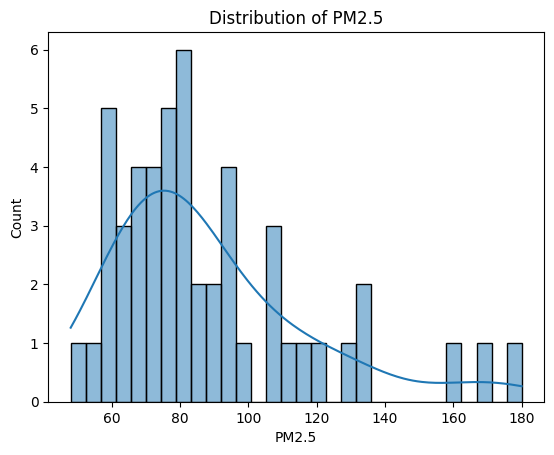

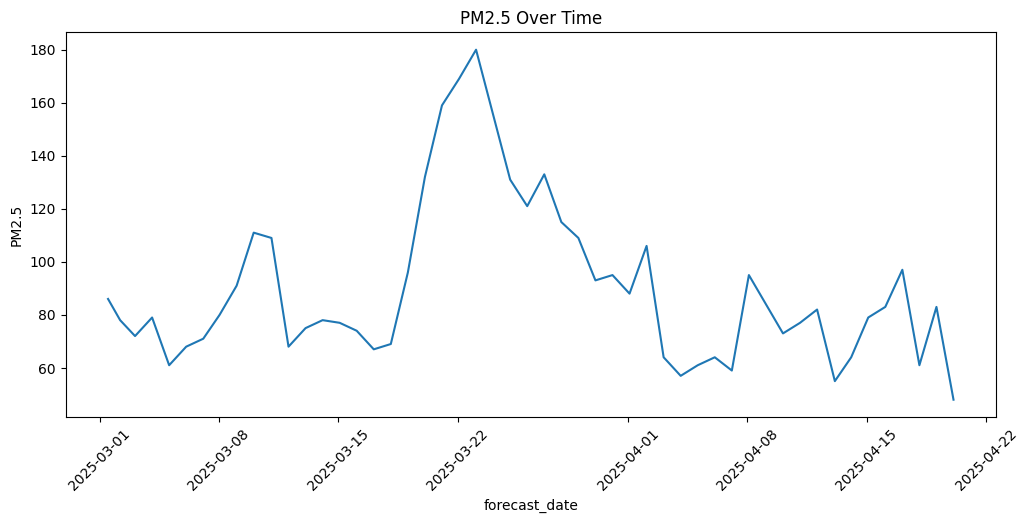

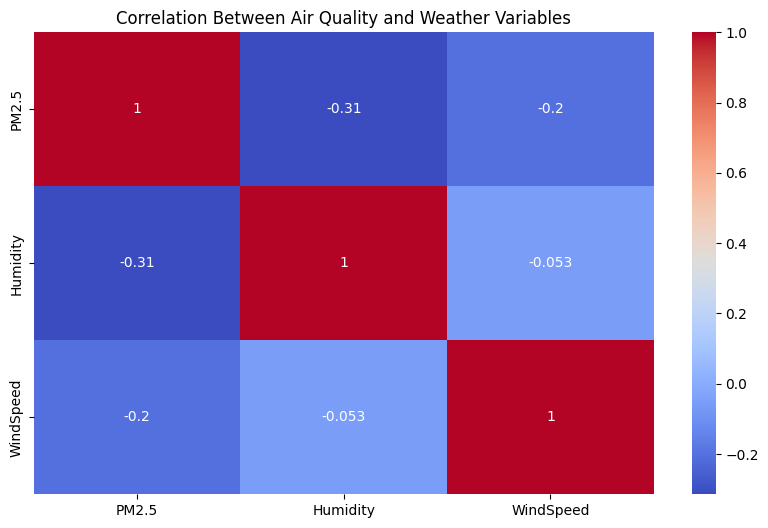

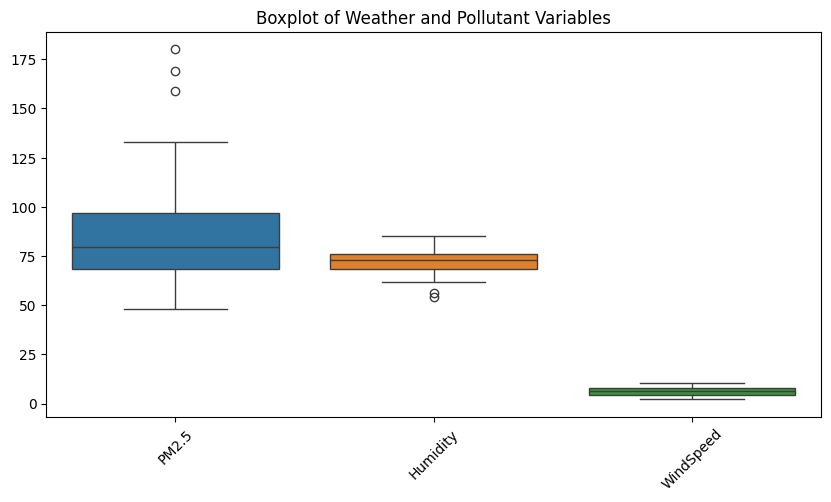

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram of PM2.5
sns.histplot(hypothesis_1_df['PM2.5'], bins=30, kde=True)
plt.title("Distribution of PM2.5")
plt.show()

# Time series of PM2.5
hypothesis_1_df['forecast_date'] = pd.to_datetime(hypothesis_1_df['Timestamp'])
hypothesis_1_df = hypothesis_1_df.sort_values('forecast_date')
plt.figure(figsize=(12, 5))
sns.lineplot(x='forecast_date', y='PM2.5', data=hypothesis_1_df)
plt.title("PM2.5 Over Time")
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(hypothesis_1_df[outlier_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Air Quality and Weather Variables")
plt.show()

# Boxplot for outlier visualization
plt.figure(figsize=(10, 5))
sns.boxplot(data=hypothesis_1_df[outlier_cols])
plt.title("Boxplot of Weather and Pollutant Variables")
plt.xticks(rotation=45)
plt.show()

In [55]:
subset = hypothesis_1_df[(hypothesis_1_df['WindSpeed'] < 6.0) & (hypothesis_1_df['Humidity'] > 70)]
pm25_values = subset['PM2.5'].dropna()
print(f"Filtered sample size: {len(pm25_values)}")

Filtered sample size: 13


In [56]:
from scipy import stats

# H0: mean = 100
t_stat, p_value = stats.ttest_1samp(pm25_values, 100)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.5f}")

T-statistic: -4.944
P-value: 0.00034


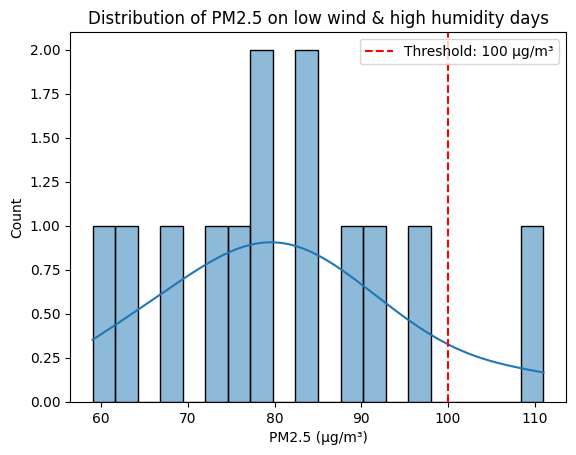

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(pm25_values, bins=20, kde=True)
plt.axvline(100, color='r', linestyle='--', label='Threshold: 100 µg/m³')
plt.title("Distribution of PM2.5 on low wind & high humidity days")
plt.xlabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()

In [58]:
alpha = 0.05
if p_value < alpha:
    print("Reject H₀ → PM2.5 is significantly higher under low wind & high humidity.")
else:
    print("Fail to reject H₀ → No significant difference in PM2.5 under those conditions.")

Reject H₀ → PM2.5 is significantly higher under low wind & high humidity.


In [59]:
features = ['Humidity', 'WindSpeed']
target = 'PM2.5'

X = hypothesis_1_df[features]
y = hypothesis_1_df[target]

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [62]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} µg/m³")
print(f"R² Score: {r2:.2f}")

MAE: 19.76 µg/m³
R² Score: 0.08


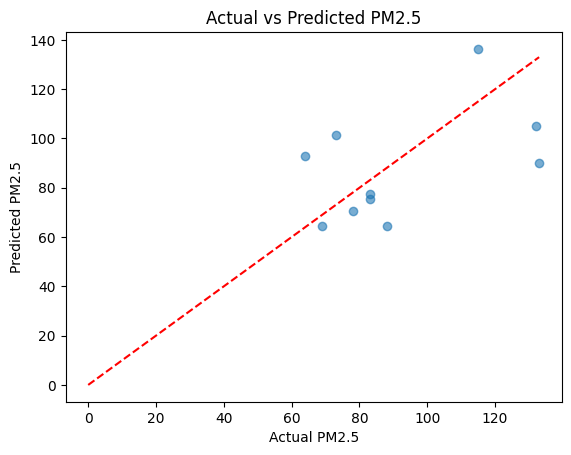

In [63]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs Predicted PM2.5")
plt.show()

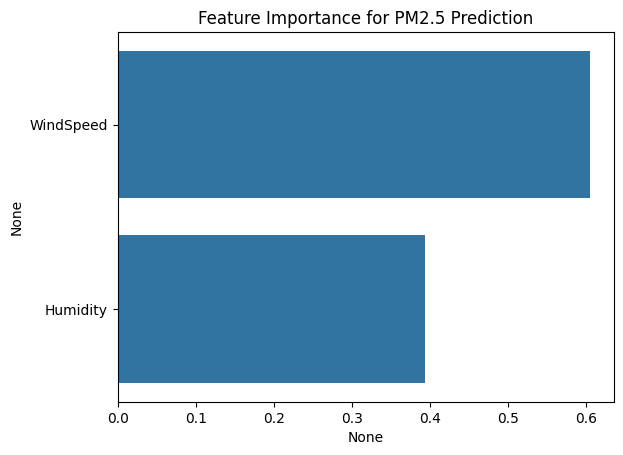

In [64]:
import seaborn as sns

importances = model.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

sns.barplot(x=feat_importance, y=feat_importance.index)
plt.title("Feature Importance for PM2.5 Prediction")
plt.show()

### 📌 Hypothesis 2
####  H₀ (Null): There is no significant difference in PM2.5 levels on rainy days in Bangkok.
####  H₁ (Alt): There is a significant difference in PM2.5 levels on rainy days in Bangkok.

In [65]:
# Nusrat



## Feature Selection
    
    #for rainy day we will work will below col:
    #PM2.5
    #rain
    #precipitation
    #showers
    #precipitation_probability
    #Timestamp

## Handling missing values

In [66]:
cleaned_df.isnull().sum()

Timestamp                         0
AQI                               0
PM2.5                             0
dominant_pollutant                0
pm25                              0
pm10                              0
co                                0
no2                               0
so2                               0
o3                                0
apparent_temperature              0
cloud_cover                       0
is_day                            0
precipitation                     0
precipitation_probability         0
pressure_msl                      0
rain                              0
relative_humidity_2m              0
showers                           0
surface_pressure                  0
temperature_2m                    0
visibility                        0
wind_speed_10m                    0
apparent_temperature_mean         1
cloud_cover_mean                  1
precipitation_sum                 1
precipitation_probability_mean    1
pressure_msl_mean           

## checking Data types

In [67]:
cleaned_df.dtypes

Timestamp                         datetime64[ns, UTC]
AQI                                             int64
PM2.5                                           int64
dominant_pollutant                             object
pm25                                            int64
pm10                                            int64
co                                            float64
no2                                           float64
so2                                           float64
o3                                            float64
apparent_temperature                          float32
cloud_cover                                   float32
is_day                                        float32
precipitation                                 float32
precipitation_probability                     float32
pressure_msl                                  float32
rain                                          float32
relative_humidity_2m                          float32
showers                     

In [68]:
cleaned_df['is_rainy'] = ((cleaned_df['rain'] > 0) | (cleaned_df['precipitation'] > 0) | (cleaned_df['showers'] > 0)).astype(int)
display(cleaned_df['is_rainy'])

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    1
14    0
15    0
16    1
17    1
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    1
27    0
28    0
29    0
30    1
31    1
32    1
33    1
34    0
35    0
36    0
37    1
38    0
39    0
40    0
41    1
42    0
43    0
44    0
45    1
46    0
47    0
48    1
49    1
50    1
Name: is_rainy, dtype: int32

## Define Rainy Days

## Aggregate to daily level (in hour)

In [69]:
cleaned_df['date'] = cleaned_df['Timestamp'].dt.date
daily_df = cleaned_df.groupby('date').agg({
    'PM2.5': 'mean',  # Daily average PM2.5
    'is_rainy': 'max'  # 1 if any rain occurred that day
}).reset_index()
print(daily_df)

          date  PM2.5  is_rainy
0   2025-03-01   86.0         0
1   2025-03-02   78.0         0
2   2025-03-03   72.0         0
3   2025-03-04   79.0         0
4   2025-03-05   61.0         0
5   2025-03-06   68.0         0
6   2025-03-07   71.0         0
7   2025-03-08   80.0         0
8   2025-03-09   91.0         0
9   2025-03-10  111.0         0
10  2025-03-11  109.0         0
11  2025-03-12   68.0         1
12  2025-03-13   75.0         0
13  2025-03-14   78.0         1
14  2025-03-15   77.0         0
15  2025-03-16   74.0         0
16  2025-03-17   67.0         1
17  2025-03-18   69.0         1
18  2025-03-19   96.0         0
19  2025-03-20  132.0         0
20  2025-03-21  159.0         0
21  2025-03-22  169.0         0
22  2025-03-23  180.0         0
23  2025-03-24  207.0         0
24  2025-03-25  131.0         0
25  2025-03-26  121.0         0
26  2025-03-27  133.0         1
27  2025-03-28  115.0         0
28  2025-03-29  109.0         0
29  2025-03-30   93.0         0
30  2025

# EDA

In [70]:
print(cleaned_df[['PM2.5', 'rain', 'precipitation', 'showers']].describe())

            PM2.5  rain  precipitation    showers
count   51.000000  51.0      51.000000  51.000000
mean    90.862745   0.0       0.096078   0.096078
std     33.276430   0.0       0.319350   0.319350
min     48.000000   0.0       0.000000   0.000000
25%     68.500000   0.0       0.000000   0.000000
50%     80.000000   0.0       0.000000   0.000000
75%    101.500000   0.0       0.100000   0.100000
max    207.000000   0.0       2.200000   2.200000


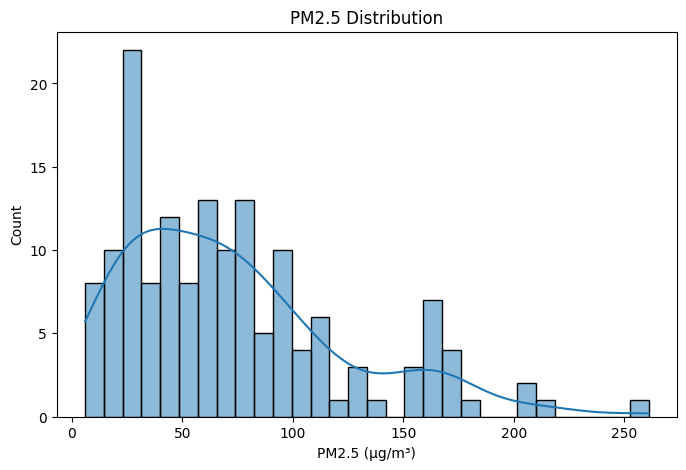

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot(df['PM2.5'], bins=30, kde=True)
plt.title('PM2.5 Distribution')
plt.xlabel('PM2.5 (µg/m³)')
plt.show()

In [72]:
display(cleaned_df[['rain', 'precipitation', 'showers']].corr())

,rain,precipitation,showers
rain,NaN,NaN,NaN
precipitation,NaN,1.0,1.0
showers,NaN,1.0,1.0


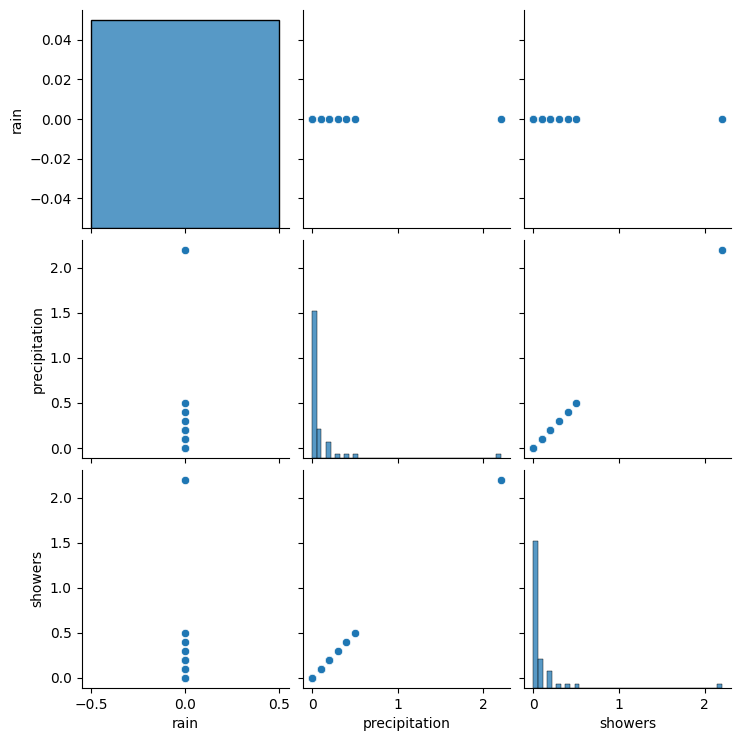

In [73]:
sns.pairplot(cleaned_df[['rain', 'precipitation', 'showers']])
plt.show()

## Handling outliers

In [74]:
Q1 = df['PM2.5'].quantile(0.25)
Q3 = df['PM2.5'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cleaned_df2 = cleaned_df[(cleaned_df['PM2.5'] >= lower_bound) & (cleaned_df['PM2.5'] <= upper_bound)]
display(cleaned_df2)

,Timestamp,AQI,PM2.5,dominant_pollutant,pm25,pm10,co,no2,so2,o3,...,pressure_msl_mean,rain_sum,relative_humidity_2m_mean,showers_sum,surface_pressure_mean,temperature_2m_mean,visibility_mean,wind_speed_10m_mean,is_rainy,date
0,2025-03-01 12:00:00+00:00,86,86,pm25,86,50,0.1,0.6,0.6,20.5,...,1008.516602,0.0,76.166664,0.000000,1008.061218,29.345329,24140.000000,7.968113,0,2025-03-01
1,2025-03-02 05:00:00+00:00,78,78,pm25,78,53,0.1,1.2,0.6,13.4,...,1008.320862,0.0,75.958336,0.000000,1007.865906,29.601585,24140.000000,8.818902,0,2025-03-02
2,2025-03-03 02:00:00+00:00,72,72,pm25,72,50,0.1,2.4,0.6,2.4,...,1008.062439,0.0,74.333336,0.000000,1007.607361,29.378668,24140.000000,9.749820,0,2025-03-03
3,2025-03-04 02:00:00+00:00,79,79,pm25,79,53,0.1,2.4,0.6,3.6,...,1007.558167,0.0,74.583336,0.000000,1007.103516,29.507833,24140.000000,8.836523,0,2025-03-04
4,2025-03-05 02:00:00+00:00,61,61,pm25,61,50,0.1,3.5,0.6,4.0,...,1008.612488,0.0,75.458336,0.000000,1008.157043,29.457834,24140.000000,8.449785,0,2025-03-05
5,2025-03-06 02:00:00+00:00,68,68,pm25,68,39,0.1,3.5,0.6,4.0,...,1009.204102,0.0,78.000000,1.800000,1008.747803,28.951584,23837.500000,7.410603,0,2025-03-06
6,2025-03-07 02:00:00+00:00,71,71,pm25,71,17,0.1,1.2,0.6,9.9,...,1011.083313,0.0,77.000000,5.500000,1010.623047,26.989082,20507.500000,7.471170,0,2025-03-07
7,2025-03-08 01:00:00+00:00,80,80,pm25,80,25,0.1,1.8,0.6,9.9,...,1012.058289,0.0,67.125000,0.000000,1011.600281,28.701582,24140.000000,4.566617,0,2025-03-08
8,2025-03-09 01:00:00+00:00,91,91,pm25,91,41,0.1,2.4,0.6,4.8,...,1011.624939,0.0,64.958336,0.000000,1011.169678,30.386995,24140.000000,4.744283,0,2025-03-09
9,2025-03-10 01:00:00+00:00,111,111,pm25,111,50,0.1,2.4,0.6,9.9,...,1010.466736,0.0,69.416664,0.100000,1010.012207,30.697416,24140.000000,4.834938,0,2025-03-10


## Validate Data

In [75]:
print(cleaned_df['PM2.5'].describe())

count     51.000000
mean      90.862745
std       33.276430
min       48.000000
25%       68.500000
50%       80.000000
75%      101.500000
max      207.000000
Name: PM2.5, dtype: float64


In [76]:
print(cleaned_df['is_rainy'].value_counts())

0    36
1    15
Name: is_rainy, dtype: int64


In [77]:
print(cleaned_df['Timestamp'].min(), cleaned_df['Timestamp'].max())

2025-03-01 12:00:00+00:00 2025-04-20 02:00:00+00:00


## Split data

In [78]:
rainy_pm25 = cleaned_df[cleaned_df['is_rainy'] == 1]['PM2.5']
non_rainy_pm25 = cleaned_df[cleaned_df['is_rainy'] == 0]['PM2.5']

## Check Normality (e.g., Shapiro-Wilk test):

In [79]:
from scipy.stats import shapiro
print(shapiro(rainy_pm25))
print(shapiro(non_rainy_pm25))

ShapiroResult(statistic=0.9168524373240399, pvalue=0.1724437116036121)
ShapiroResult(statistic=0.8526456808705389, pvalue=0.00021910793570420454)


## Statistical Test:

In [80]:
from scipy.stats import ttest_ind, mannwhitneyu
# T-test
t_stat, p_value = ttest_ind(rainy_pm25, non_rainy_pm25, equal_var=False)
print(f"T-test p-value: {p_value}")
# Mann-Whitney U
u_stat, p_value = mannwhitneyu(rainy_pm25, non_rainy_pm25)
print(f"Mann-Whitney U p-value: {p_value}")

T-test p-value: 0.034602713922763685
Mann-Whitney U p-value: 0.0879975275686193
